# UVOD U ZNANOST O PODACIMA
## Projekt: Early-Stage Alzheimer's Disease Prediction Using Machine Learning Models
U ovom projektu bavimo se razvojem modela za predikcije rane faze Alzheimerove bolesti koristeći metode strojnog učenja.
Cilj projekta je replicirati rezultate postojećeg istraživačkog članka koji koristi strojno učenje za klasifikaciju i predikciju rane faze Alzheimerove bolesti. Nakon uspješne replikacije, nastojat ćemo poboljšati točnost i učinkovitost modela primjenom novih metoda i prilagodbi modela.


In [148]:
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from pyparsing import Group
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from scipy import stats
import numpy as np

## Učitavanje podataka i prvi pogled na podatke


In [149]:
data = pd.read_csv('oasis_longitudinal.csv')
print(data.info())
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB
None


,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444
6,OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,F,R,90,18,3.0,27.0,0.0,1200,0.718,1.462
7,OAS2_0005,OAS2_0005_MR1,Nondemented,1,0,M,R,80,12,4.0,28.0,0.0,1689,0.712,1.039
8,OAS2_0005,OAS2_0005_MR2,Nondemented,2,1010,M,R,83,12,4.0,29.0,0.5,1701,0.711,1.032
9,OAS2_0005,OAS2_0005_MR3,Nondemented,3,1603,M,R,85,12,4.0,30.0,0.0,1699,0.705,1.033


## Priprema podataka
Prije samog čišćenja podataka potrebno je pripremiti podatke tj. grupirati pacijente te za svakog pacijenta koji ima vise od jednog posjeta, uzeti samo prvi posjet kako daljnja analiza i izračunate statistike nebi bili pristrani pacijentima koji imaju više posjeta.

In [150]:
print(f"----Broj redaka sa svim posjetama: {data.shape[0]}----")
data = data.sort_values(by='Visit', ascending=True)
data = data.groupby('Subject ID').first().reset_index()
print(f"----Broj redaka samo sa prvim posjetama: {data.shape[0]}----")

data

----Broj redaka sa svim posjetama: 373----
----Broj redaka samo sa prvim posjetama: 150----


,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
2,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444
3,OAS2_0005,OAS2_0005_MR1,Nondemented,1,0,M,R,80,12,4.0,28.0,0.0,1689,0.712,1.039
4,OAS2_0007,OAS2_0007_MR1,Demented,1,0,M,R,71,16,NaN,28.0,0.5,1357,0.748,1.293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,OAS2_0182,OAS2_0182_MR1,Demented,1,0,M,R,73,12,NaN,23.0,0.5,1661,0.698,1.056
146,OAS2_0183,OAS2_0183_MR1,Nondemented,1,0,F,R,66,13,2.0,30.0,0.0,1495,0.746,1.174
147,OAS2_0184,OAS2_0184_MR1,Demented,1,0,F,R,72,16,3.0,24.0,0.5,1354,0.733,1.296
148,OAS2_0185,OAS2_0185_MR1,Demented,1,0,M,R,80,16,1.0,28.0,0.5,1704,0.711,1.030


## Čišćenje podataka
Prije prikazivanja pojedinih statistika o podacima, pronaći ćemo monotone i konstantne vrijednosti te ih ukloniti kako nebi nepotrebno smetali pri analizi podataka. Također osim monotonih i konstantnih podataka provest ćemo i zamjenu/uklanjanje nedostajućih vrijednosti s određenim postupkom za konkretan stupac.
### Pronalazak i uklanjanje konstantnih i monotonih vrijednosti

In [151]:
print(f"----Broj redaka: {data.shape[0]}----")
print(data.nunique())

----Broj redaka: 150----
Subject ID    150
MRI ID        150
Group           3
Visit           1
MR Delay        1
M/F             2
Hand            1
Age            34
EDUC           12
SES             5
MMSE           13
CDR             3
eTIV          131
nWBV           90
ASF           129
dtype: int64


Prethodnim ispisom mozemo zaključiti da su stupci Subject ID i MRI ID monotoni i nemamo koristi od njih jer svaki redak ima jedinstvenu vrijednost, takoder mozemo zakljuciti da su stupci Visit, MR Delay, Hand konstantni budući da svaki redak ima jednaku vrijednost stoga izbacujemo navedene stupce.


In [152]:
data.drop(['Subject ID', 'MRI ID', 'Visit', 'MR Delay', 'Hand'], axis=1, inplace=True)
data

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Demented,M,75,12,NaN,23.0,0.5,1678,0.736,1.046
2,Nondemented,F,88,18,3.0,28.0,0.0,1215,0.710,1.444
3,Nondemented,M,80,12,4.0,28.0,0.0,1689,0.712,1.039
4,Demented,M,71,16,NaN,28.0,0.5,1357,0.748,1.293
...,...,...,...,...,...,...,...,...,...,...
145,Demented,M,73,12,NaN,23.0,0.5,1661,0.698,1.056
146,Nondemented,F,66,13,2.0,30.0,0.0,1495,0.746,1.174
147,Demented,F,72,16,3.0,24.0,0.5,1354,0.733,1.296
148,Demented,M,80,16,1.0,28.0,0.5,1704,0.711,1.030


### Zamjena/uklanjanje nedostajućih vrijednosti s određenim postupkom
Pretrazujemo stupce/varijable na kojima imamo nedostajuće vrijednosti.

In [153]:
print("Broj nedostajućih vrijednosti po stupcima:\n")
missing_values = data.isnull().sum()
print(missing_values)

Broj nedostajućih vrijednosti po stupcima:

Group    0
M/F      0
Age      0
EDUC     0
SES      8
MMSE     0
CDR      0
eTIV     0
nWBV     0
ASF      0
dtype: int64


Nakon uzimanja konteksta stupca u obzir, nedostajuće vrijednosti zamjenjujemo medijanom kako bi bile iz domene vrijednosti podataka u stupcu (npr. SES nema smisla da postavimo kao decimalan broj srednje vrijednosti jer su SES vrijednosti cijeli brojevi od 1 do 5)

In [154]:
data.loc[data.SES.isna(), 'SES'] = data.loc[:, 'SES'].median()
data

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Demented,M,75,12,2.0,23.0,0.5,1678,0.736,1.046
2,Nondemented,F,88,18,3.0,28.0,0.0,1215,0.710,1.444
3,Nondemented,M,80,12,4.0,28.0,0.0,1689,0.712,1.039
4,Demented,M,71,16,2.0,28.0,0.5,1357,0.748,1.293
...,...,...,...,...,...,...,...,...,...,...
145,Demented,M,73,12,2.0,23.0,0.5,1661,0.698,1.056
146,Nondemented,F,66,13,2.0,30.0,0.0,1495,0.746,1.174
147,Demented,F,72,16,3.0,24.0,0.5,1354,0.733,1.296
148,Demented,M,80,16,1.0,28.0,0.5,1704,0.711,1.030


## Pretvorba kategorijskih podataka u numeričke
Prije same pretvorbe kategorijskih podataka u numeričke ugrubo ćemo prikazati osnovne statistike: srednju (mean), centralnu (median), minimalnu i maksimalnu vrijednost za numeričke podatke, te učestalost pojavljivanja svake vrijednosti za kategorijske podatke.

In [155]:
# prikaz numerickih podataka
print("----NUMERICKI PODACI----")
numerical_columns = data.select_dtypes(include=['number']).columns.tolist()
print(data.loc[:, numerical_columns].agg(['mean', 'median', 'max', 'min']))

# prikaz ucestalosti pojavljivanja svake vrijednosti
print("----KATEGORIJSKI PODACI----")
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
for column in categorical_columns:
    print("---------------")
    print(data.loc[:, column].value_counts())

----NUMERICKI PODACI----
              Age       EDUC       SES   MMSE   CDR         eTIV      nWBV  \
mean    75.446667  14.533333  2.466667  27.56  0.26  1474.426667  0.736073   
median  75.000000  14.000000  2.000000  29.00  0.00  1453.500000  0.735000   
max     96.000000  23.000000  5.000000  30.00  1.00  1987.000000  0.837000   
min     60.000000   6.000000  1.000000  17.00  0.00  1123.000000  0.660000   

             ASF  
mean    1.206333  
median  1.207500  
max     1.563000  
min     0.883000  
----KATEGORIJSKI PODACI----
---------------
Group
Nondemented    72
Demented       64
Converted      14
Name: count, dtype: int64
---------------
M/F
F    88
M    62
Name: count, dtype: int64


In [156]:
encoder = LabelEncoder()
group_mapping = {'Nondemented': 0, 'Demented': 1, 'Converted': 2}
data['Group'] = data['Group'].map(group_mapping)
data['Group'] = data['Group'].replace(2, 1)
print("Mapiranje za varijablu Group:")
print(group_mapping)


data['M/F'] = encoder.fit_transform(data['M/F'])
print("Mapiranje za varijablu M/F:")
print(dict(zip(encoder.classes_, range(len(encoder.classes_)))))

data

Mapiranje za varijablu Group:
{'Nondemented': 0, 'Demented': 1, 'Converted': 2}
Mapiranje za varijablu M/F:
{'F': 0, 'M': 1}


,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,1,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,1,1,75,12,2.0,23.0,0.5,1678,0.736,1.046
2,0,0,88,18,3.0,28.0,0.0,1215,0.710,1.444
3,0,1,80,12,4.0,28.0,0.0,1689,0.712,1.039
4,1,1,71,16,2.0,28.0,0.5,1357,0.748,1.293
...,...,...,...,...,...,...,...,...,...,...
145,1,1,73,12,2.0,23.0,0.5,1661,0.698,1.056
146,0,0,66,13,2.0,30.0,0.0,1495,0.746,1.174
147,1,0,72,16,3.0,24.0,0.5,1354,0.733,1.296
148,1,1,80,16,1.0,28.0,0.5,1704,0.711,1.030


Prethodnim prikazom vidimo kako su jedine kategorijske varijable Group (koja je ujedno i ciljna varijabla) i M/F (koja predstavlja spol). Sljedeći korak je pretvorba navednih kategorijskih varijabli u numeričke vrijednosti. Neuredene kategorije tj. kategoricke varijable koje nemaju smisleni poredak spadaju u kategoriju nominalnih podataka te za njih koristimo one-hot encoding (svaka kategorija odvaja se u zasebni stupac) za pretvorbu.
Uredene kategorije tj. kategoričke varijable koje imaju smisleni poredak (loše, dobro, odlično) spadaju u kategoriju ordinalnih podataka te za njih koristimo label encoding (svaka kategorija ostaje u istom stupcu samo su drugčije mapirane npr. kodovima 1, 2, 3).
Nase kategorijske varijable su uređene pa stoga koristimo label encoding.

## Izbacivanje stršećih vrijednosti
Za izbacivanje stršećih vrijednosti koristit ćemo metodu Z-score koja mjeri koliko je svaka vrijednost udaljena od srednje vrijednosti u jedinicama standardne devijacije.

Prije samog postupka izbacivanja prikazat ćemo stršeće podatke box plot dijagramom.

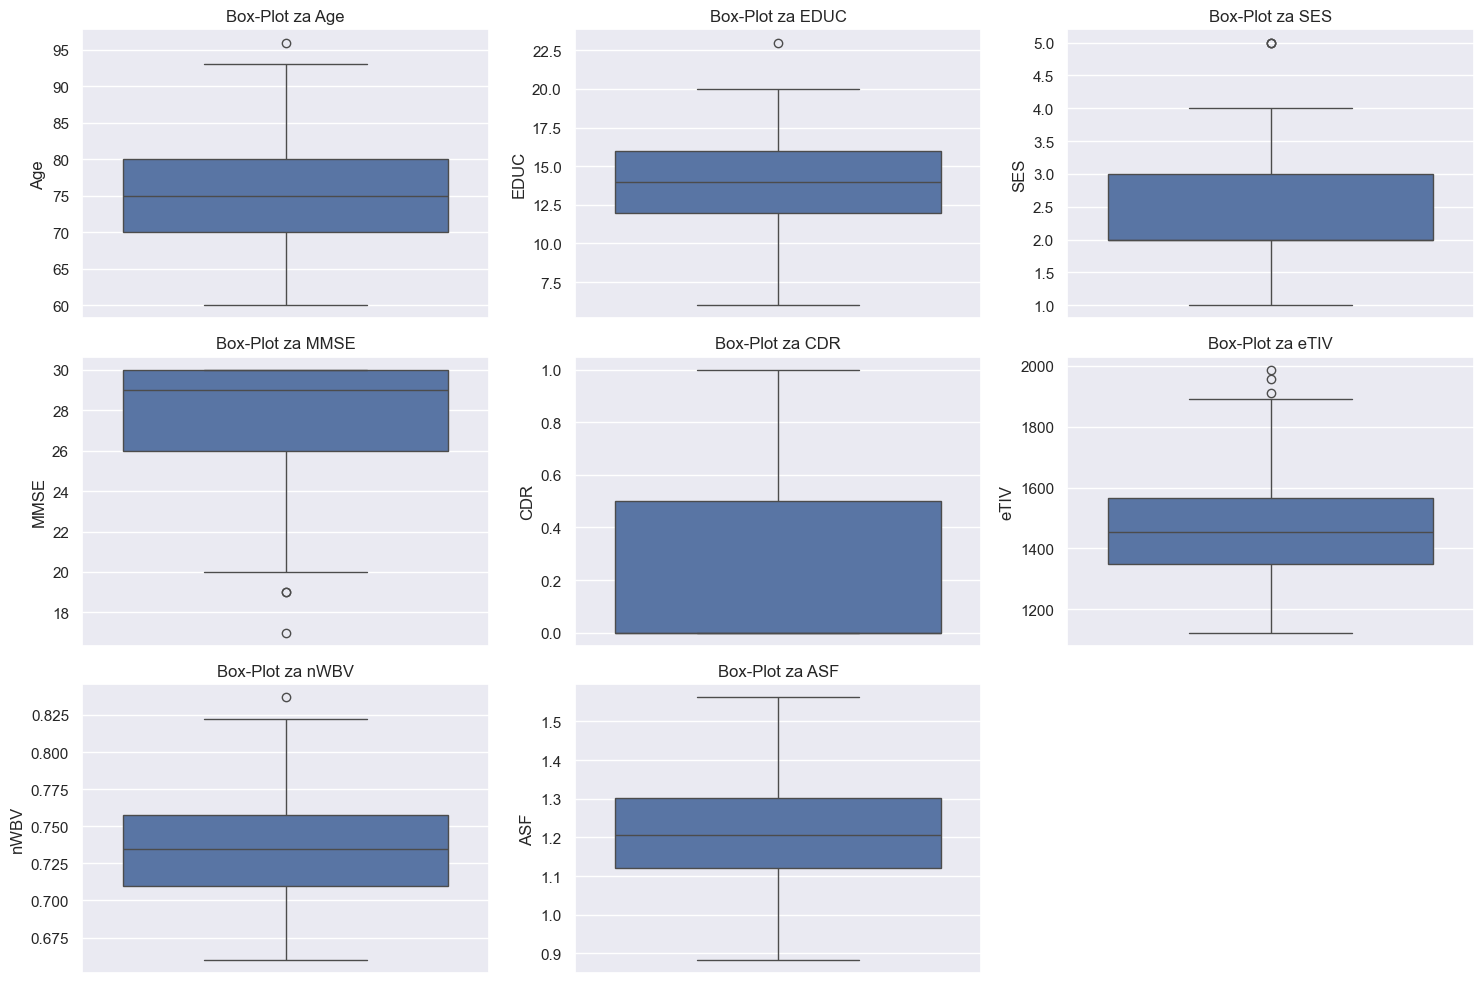

In [157]:
numeric_columns = data.select_dtypes(include=['number']).columns.drop(['M/F', 'Group'])

plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot((len(numeric_columns) + 2) // 3, 3, i)
    sns.boxplot(y=data[column])
    plt.title(f"Box-Plot za {column}")
    plt.ylabel(column)
    plt.tight_layout()

plt.show()

### Postupak izbacivanja stršećih vrijednosti

In [158]:
print(f"----Broj redaka prije izbacivanja strsecih vrijednosti: {data.shape[0]}----")
z_scores = np.abs(stats.zscore(data.select_dtypes(include=['number'])))
data = data[(z_scores < 3).all(axis=1)] 
print(f"----Broj redaka nakon izbacivanja strsecih vrijednosti: {data.shape[0]}----")

----Broj redaka prije izbacivanja strsecih vrijednosti: 150----
----Broj redaka nakon izbacivanja strsecih vrijednosti: 149----


## Pogled osnovnih statistika nakon kompletne pripreme i čišćenja podataka

In [159]:
data.describe()

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000
mean,0.516779,0.409396,75.536913,14.550336,2.456376,27.630872,0.258389,1474.087248,0.736101,1.206705
std,0.501404,0.493381,7.489203,2.876833,1.099651,2.848302,0.326757,175.223407,0.036580,0.138254
min,0.000000,0.000000,60.000000,6.000000,1.000000,19.000000,0.000000,1123.000000,0.660000,0.883000
25%,0.000000,0.000000,70.000000,12.000000,2.000000,26.000000,0.000000,1346.000000,0.710000,1.119000
50%,1.000000,0.000000,75.000000,14.000000,2.000000,29.000000,0.000000,1453.000000,0.736000,1.208000
75%,1.000000,1.000000,80.000000,16.000000,3.000000,30.000000,0.500000,1568.000000,0.758000,1.304000
max,1.000000,1.000000,96.000000,23.000000,5.000000,30.000000,1.000000,1987.000000,0.837000,1.563000


## Normalizacija podataka
Normalizirane podatke spremit ćemo u kopiju varijable data, budući da ćemo za vizualizaciju koristiti podatke koji nisu normalizirani. Koristimo MinMaxScaler koji koristi linearnu transformaciju vrijednosti na raspon 0-1 sljedeceom formulom: x_normalized = (x – min) / (max – min)

In [160]:
data_normalized = data.copy()
scaler = MinMaxScaler()
numerical_columns = data_normalized.select_dtypes(include=['number']).columns.tolist()
data_normalized[numerical_columns] = scaler.fit_transform(data_normalized[numerical_columns])

data_normalized

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0.0,1.0,0.750000,0.470588,0.25,0.727273,0.0,1.000000,0.203390,0.000000
1,1.0,1.0,0.416667,0.352941,0.25,0.363636,0.5,0.642361,0.429379,0.239706
2,0.0,0.0,0.777778,0.705882,0.50,0.818182,0.0,0.106481,0.282486,0.825000
3,0.0,1.0,0.555556,0.352941,0.75,0.818182,0.0,0.655093,0.293785,0.229412
4,1.0,1.0,0.305556,0.588235,0.25,0.818182,0.5,0.270833,0.497175,0.602941
...,...,...,...,...,...,...,...,...,...,...
145,1.0,1.0,0.361111,0.352941,0.25,0.363636,0.5,0.622685,0.214689,0.254412
146,0.0,0.0,0.166667,0.411765,0.25,1.000000,0.0,0.430556,0.485876,0.427941
147,1.0,0.0,0.333333,0.588235,0.50,0.454545,0.5,0.267361,0.412429,0.607353
148,1.0,1.0,0.555556,0.588235,0.00,0.818182,0.5,0.672454,0.288136,0.216176


## Vizualizacija podataka nakon čišćenja

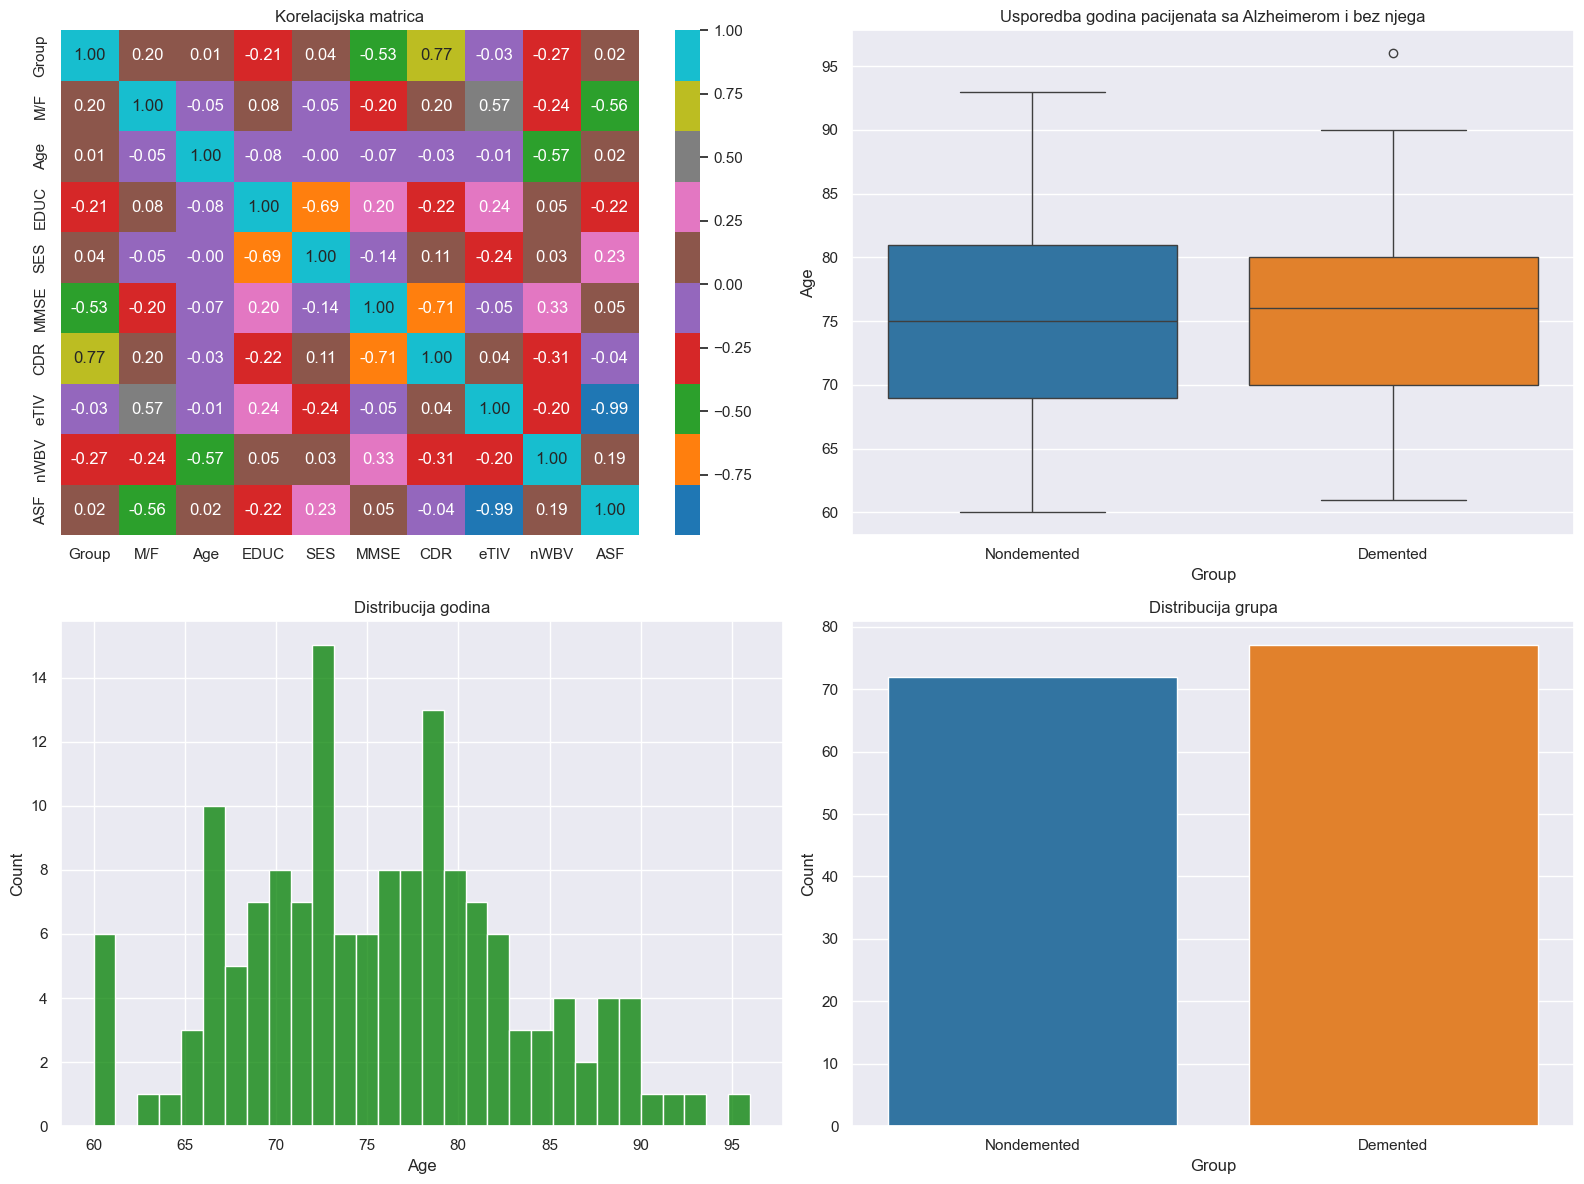

In [161]:
visualization_data = data.copy()
visualization_data['Group'] = visualization_data['Group'].replace({0: 'Nondemented', 1: 'Demented'})

numerical_columns = visualization_data.select_dtypes(include=['number']).columns.tolist()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.heatmap(data.corr(), annot=True, cmap='tab10', fmt=".2f", ax=axes[0, 0])
axes[0, 0].set_title("Korelacijska matrica")

sns.boxplot(data=visualization_data, x='Group', y='Age', ax=axes[0, 1], palette='tab10', hue='Group')
axes[0, 1].set_title('Usporedba godina pacijenata sa Alzheimerom i bez njega')
axes[0, 1].set_xlabel('Group')
axes[0, 1].set_ylabel('Age')

sns.histplot(visualization_data['Age'], bins=30, ax=axes[1, 0], color='green')
axes[1, 0].set_title('Distribucija godina')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('Count')

sns.countplot(data=visualization_data, x='Group', palette='tab10', ax=axes[1, 1], hue='Group')
axes[1, 1].set_title('Distribucija grupa')
axes[1, 1].set_xlabel('Group')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

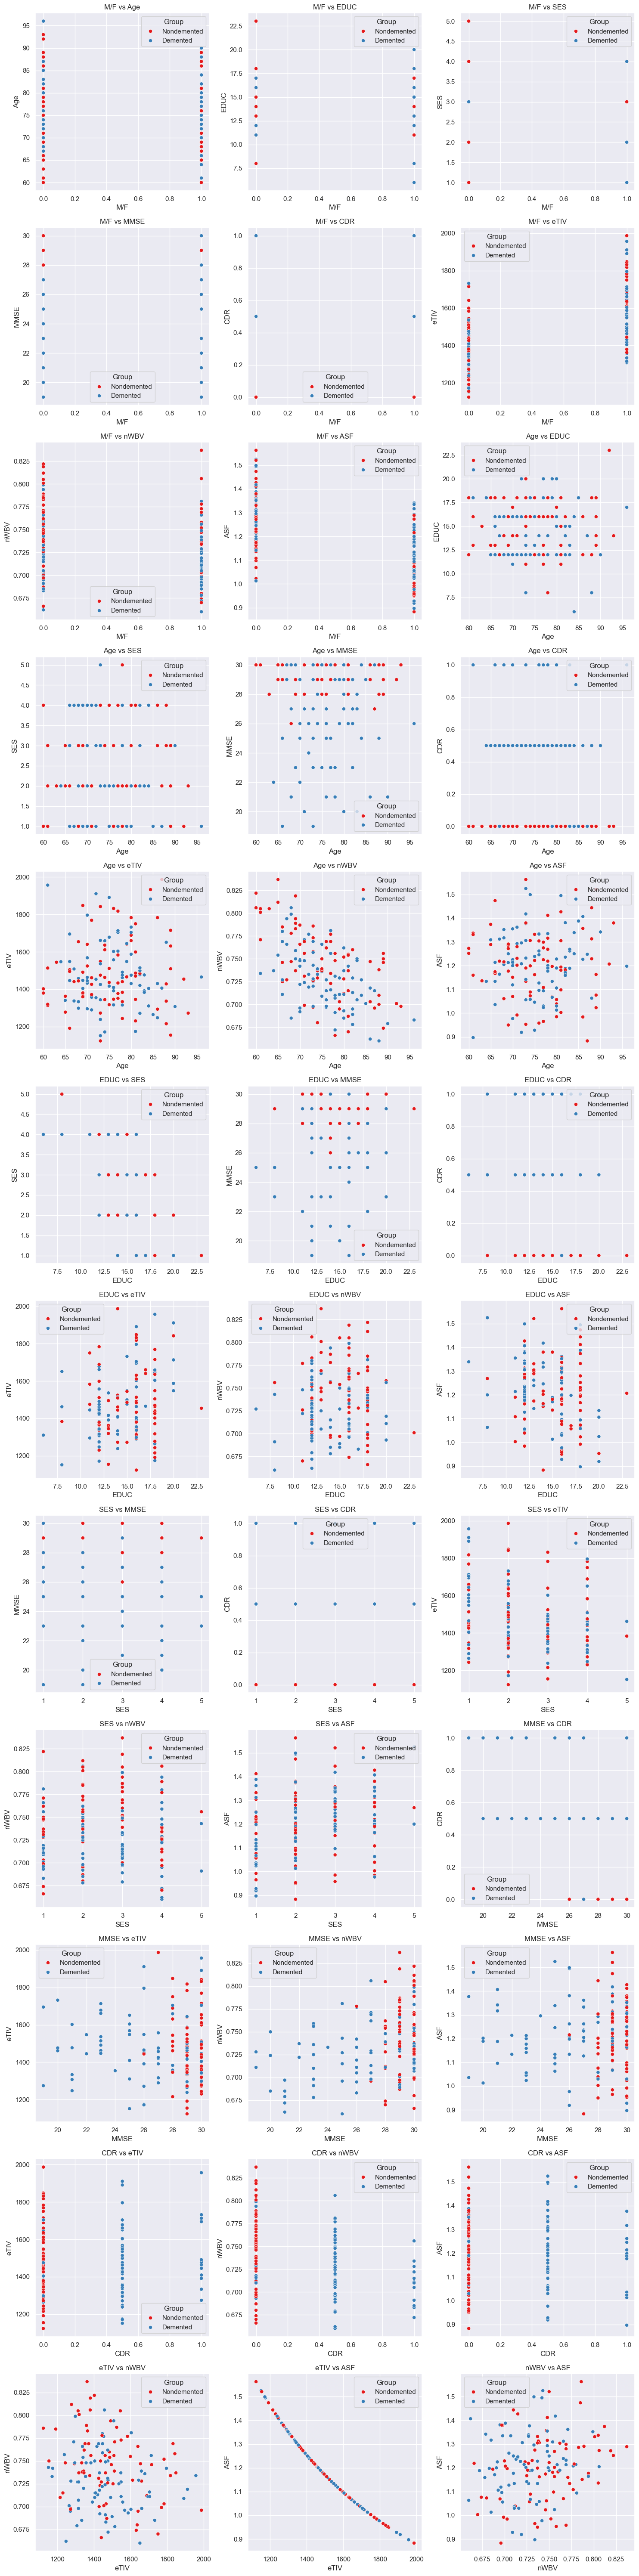

In [162]:
variables = [col for col in visualization_data.columns if col != 'Group']
variable_combinations = list(combinations(variables, 2))

n_plots = len(variable_combinations)
n_cols = 3
n_rows = math.ceil(n_plots / n_cols)

fig_, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), squeeze=False)

for ax, (var1, var2) in zip(axes.flatten(), variable_combinations):
    sns.scatterplot(data=visualization_data, x=var1, y=var2, hue='Group', palette='Set1', ax=ax)
    ax.set_title(f'{var1} vs {var2}')
    ax.set_xlabel(var1)
    ax.set_ylabel(var2)

for ax in axes.flatten()[len(variable_combinations):]:
    ax.remove()

plt.tight_layout()
plt.show()

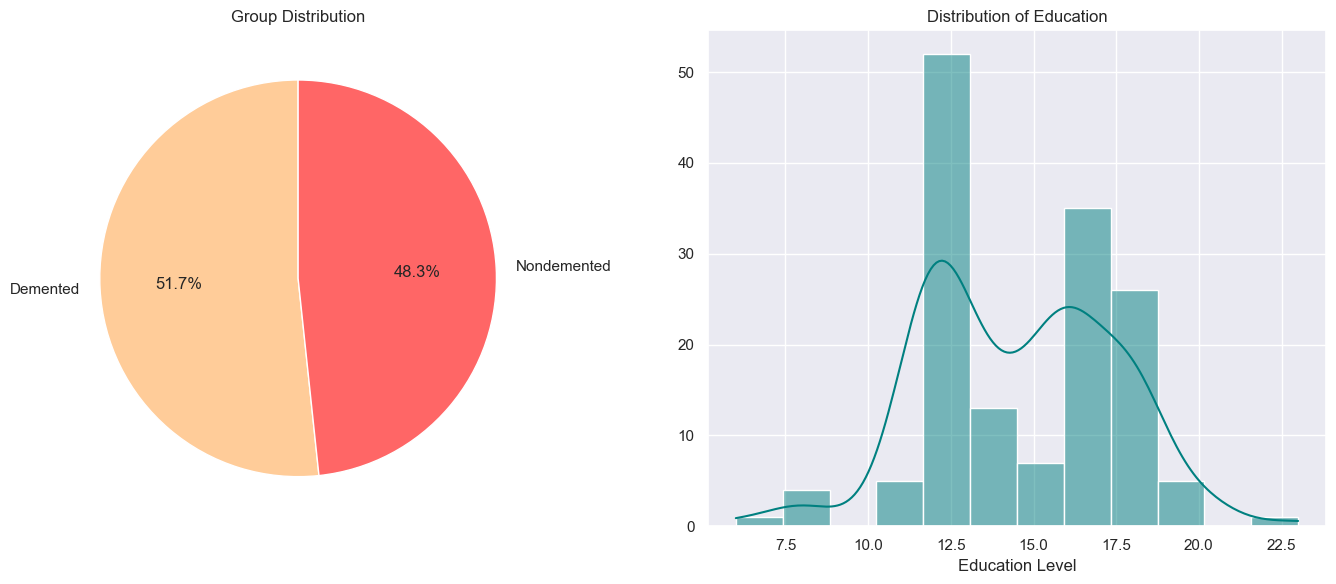

In [163]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
group_counts = visualization_data['Group'].value_counts()
group_labels = group_counts.index.tolist()  
axes[0].pie(group_counts, labels=group_labels, autopct='%1.1f%%', startangle=90, 
            colors=['#ffcc99', '#ff6666', '#66b3b3'])
axes[0].set_title('Group Distribution')

sns.histplot(visualization_data['EDUC'], kde=True, ax=axes[1], color='teal')
axes[1].set_title('Distribution of Education')
axes[1].set_xlabel('Education Level')
axes[1].set_ylabel(None) 

plt.tight_layout()
plt.show()



## Replikacija rezultata
U ovom dijelu projekta fokusiramo se na replikaciju rezultata istraživanja predstavljenog u članku. Cilj ove replikacije je provjera vjerodostojnosti i ponovljivosti dobivenih rezultata korištenjem istih metoda i skupa podataka. Time osiguravamo osnovu za daljnju analizu i unapređenje postojećih modela, što će biti tema kasnijih dijelova ovog projekta.


In [164]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

#### Budući da prema koeficijentima korelacije koji slijede varijable Group i CDR imaju jako veliku međusobnu korelaciju, izbacujemo varijablu CDR zato što ona zapravo predstavlja kliničku razinu demencije. 

In [165]:
correlation = data[['CDR', 'Group']].corr(method='spearman')
print(correlation)
data = data.drop(['CDR'], axis=1).copy()

           CDR    Group
CDR    1.00000  0.81794
Group  0.81794  1.00000


#### Na priloženom grafu vidimo da muškarci imaju veću vjerojatnost da će imati demenciju nego žene

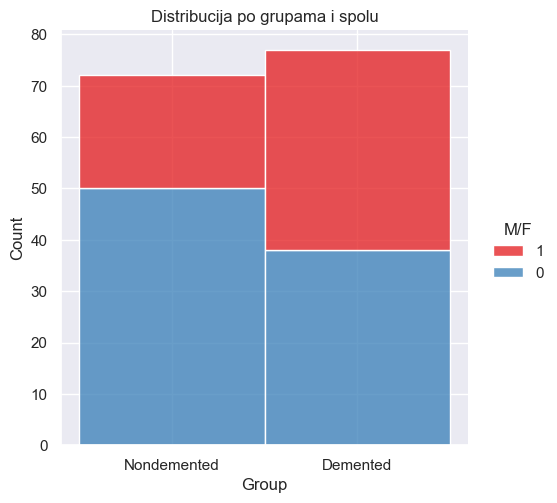

In [166]:
sns.set_theme(rc={'figure.figsize': (8,6)})
sns.displot(
    data=visualization_data, 
    x="Group", 
    hue="M/F", 
    multiple="stack", 
    palette="Set1", 
    hue_order=[1, 0]
)

plt.xlabel("Group")
plt.title("Distribucija po grupama i spolu")
plt.show()

#### Analiza MMSE rezultata za dementnu i nedementnu skupinu bolesnika

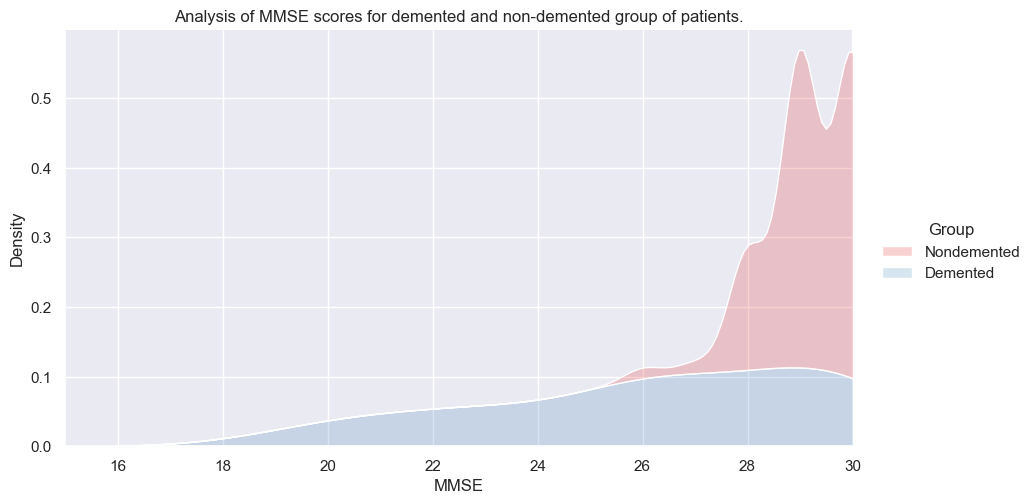

In [167]:
sns.set_theme(rc={'figure.figsize':(10,20)})
sns.displot(data=visualization_data, x="MMSE", hue="Group", multiple="stack", kind="kde", fill=True, common_norm=False, alpha=0.2, palette="Set1", height=5, aspect=16/9)
plt.title("Analysis of MMSE scores for demented and non-demented group of patients.")
plt.xlim(15, 30)
plt.show()

#### Analiza ASF, eTIV i nWBV za skupinu dementnih i nedementnih

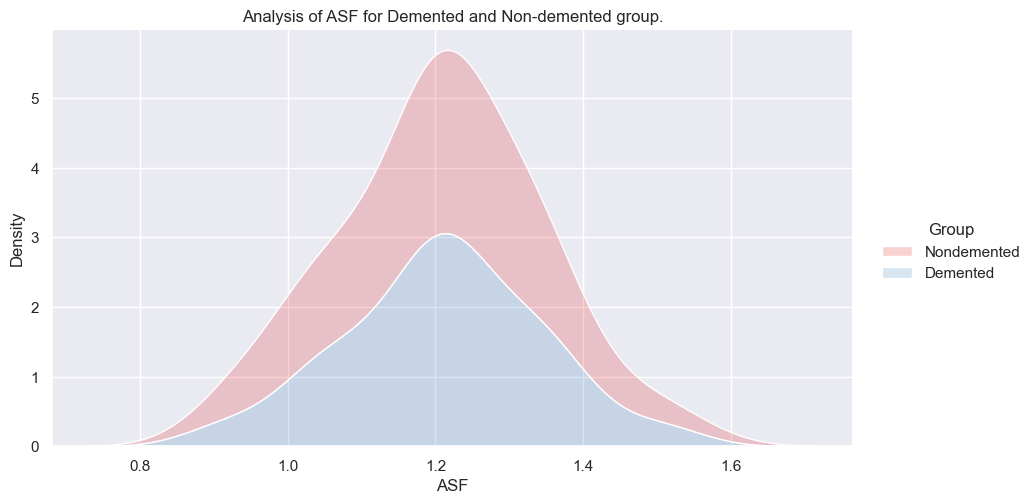

In [168]:
sns.set_theme(rc={'figure.figsize':(10,20)})
sns.displot(data=visualization_data, x="ASF", hue="Group", multiple="stack", kind="kde", fill=True, common_norm=False, alpha=0.2, palette="Set1", height=5, aspect=16/9)
plt.title("Analysis of ASF for Demented and Non-demented group.")
plt.show()

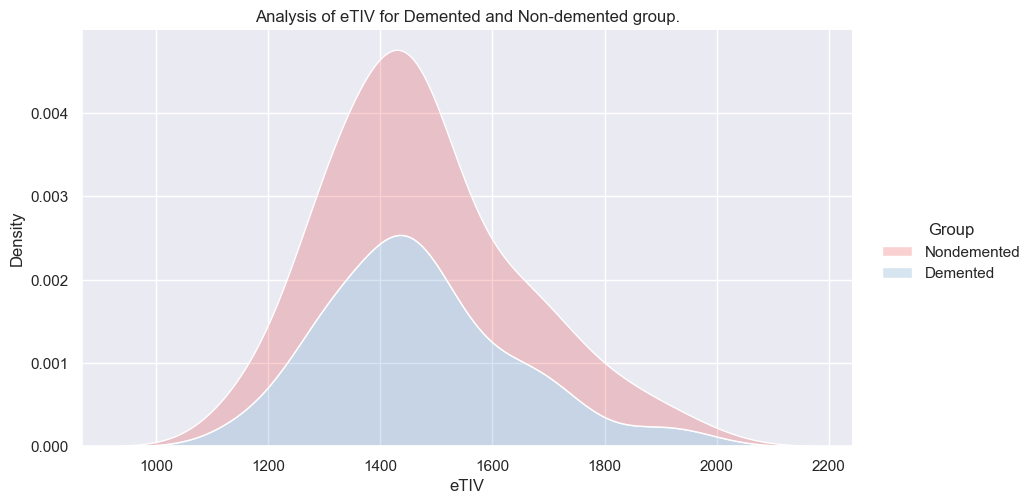

In [169]:
sns.set_theme(rc={'figure.figsize':(10,20)})
sns.displot(data=visualization_data, x="eTIV", hue="Group", multiple="stack", kind="kde", fill=True, common_norm=False, alpha=0.2, palette="Set1", height=5, aspect=16/9)
plt.title("Analysis of eTIV for Demented and Non-demented group.")
plt.show()

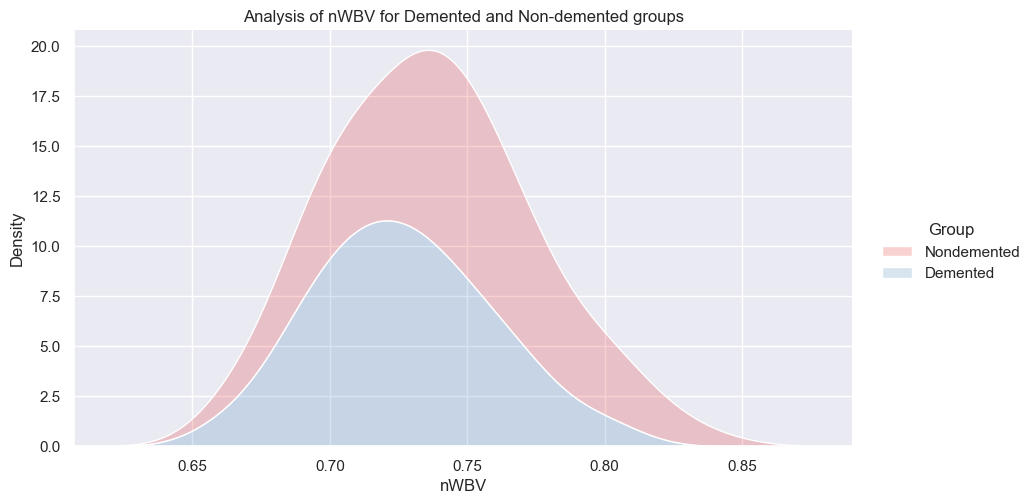

In [170]:
sns.set_theme(rc={'figure.figsize':(10,20)})
sns.displot(data=visualization_data, x="nWBV", hue="Group", multiple="stack", kind="kde", fill=True, common_norm=False, alpha=0.2, palette="Set1", height=5, aspect=16/9)
plt.title('Analysis of nWBV for Demented and Non-demented groups')
plt.show()

#### Analiza godina obrazovanja za skupinu dementnih i nedementnih

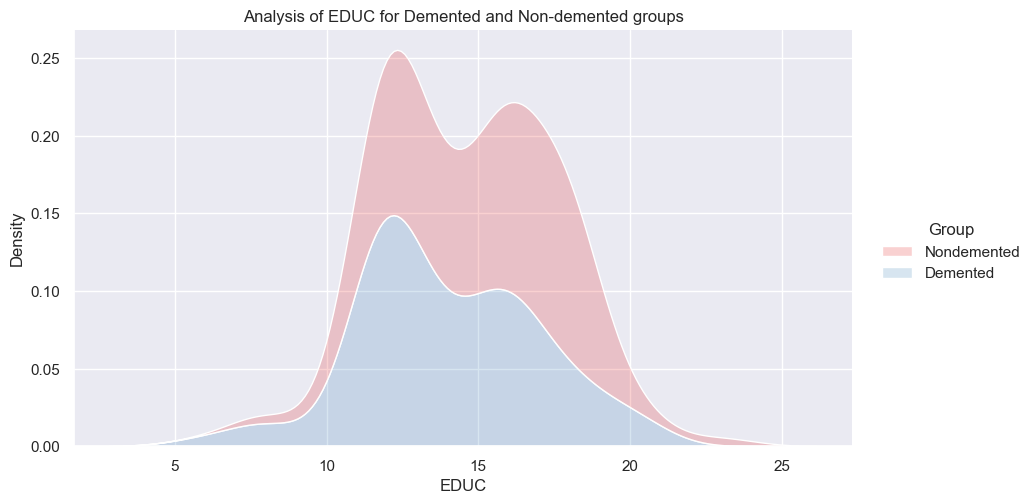

In [171]:
sns.set_theme(rc={'figure.figsize':(10,20)})
sns.displot(data=visualization_data, x="EDUC", hue="Group", multiple="stack", kind="kde", fill=True, common_norm=False, alpha=0.2, palette="Set1", height=5, aspect=16/9)
plt.title('Analysis of EDUC for Demented and Non-demented groups')
plt.show()

#### Analiza osoba pogođenih dementnom i nedementnom skupinom na temelju dobi

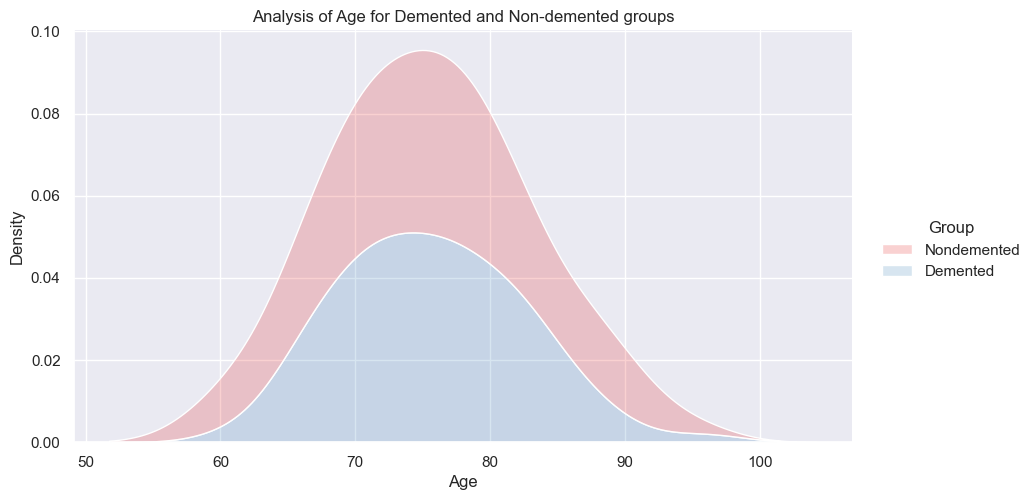

In [172]:
sns.set_theme(rc={'figure.figsize':(10,20)})
sns.displot(data=visualization_data, x="Age", hue="Group", multiple="stack", kind="kde", fill=True, common_norm=False, alpha=0.2, palette="Set1", height=5, aspect=16/9)
plt.title('Analysis of Age for Demented and Non-demented groups')
plt.show()

## Evaluacija modela 
U ovom poglavlju analiziraju se različiti modeli strojnog učenja koji su korišteni u poglavlju replikacije za predikciju i klasifikaciju Alzheimerove bolesti, te se procjenjuje njihova učinkovitost na temelju odabranih metrika evaluacije. Cilj ovog poglavlja je pružiti detaljan pregled performansi modela kako bi se usporedili dobiveni rezultati sa onima u članku.

In [173]:
X = data.drop(['Group'], axis=1)
y = data['Group']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifiers = [
    "Decision tree classifier",
    "Random forest classifier",
    "Support vector machine",
    "XGBoost",
    "Voting classifier"
]

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
df = pd.DataFrame(0.0, index=classifiers, columns=metrics)

def print_scores(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    f1_res = f1_score(y_true, y_pred, average='weighted', zero_division=1)
    df.loc[model_name] = [accuracy, precision, recall, f1_res]

    print(f"\nEvaluacija modela: {model_name}")
    print("=" * 50)
    print(f"-> Accuracy:  {accuracy*100:.2f}%")
    print(f"-> Precision: {precision:.4f}")
    print(f"-> Recall:    {recall:.4f}")
    print(f"-> F1 Score:  {f1_res:.4f}")

def print_graphs(y_true, y_pred, model, model_name):
    plt.figure(figsize=(20, 5))
    confusion_mat = confusion_matrix(y_true, y_pred)
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr)
    plt.title("AUC/ROC krivulja")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

## DECISION TREE CLASSIFIER
Testiranje preciznosti decision tree classifier modela


Evaluacija modela: Decision tree classifier
-> Accuracy:  66.67%
-> Precision: 0.6786
-> Recall:    0.6667
-> F1 Score:  0.6697


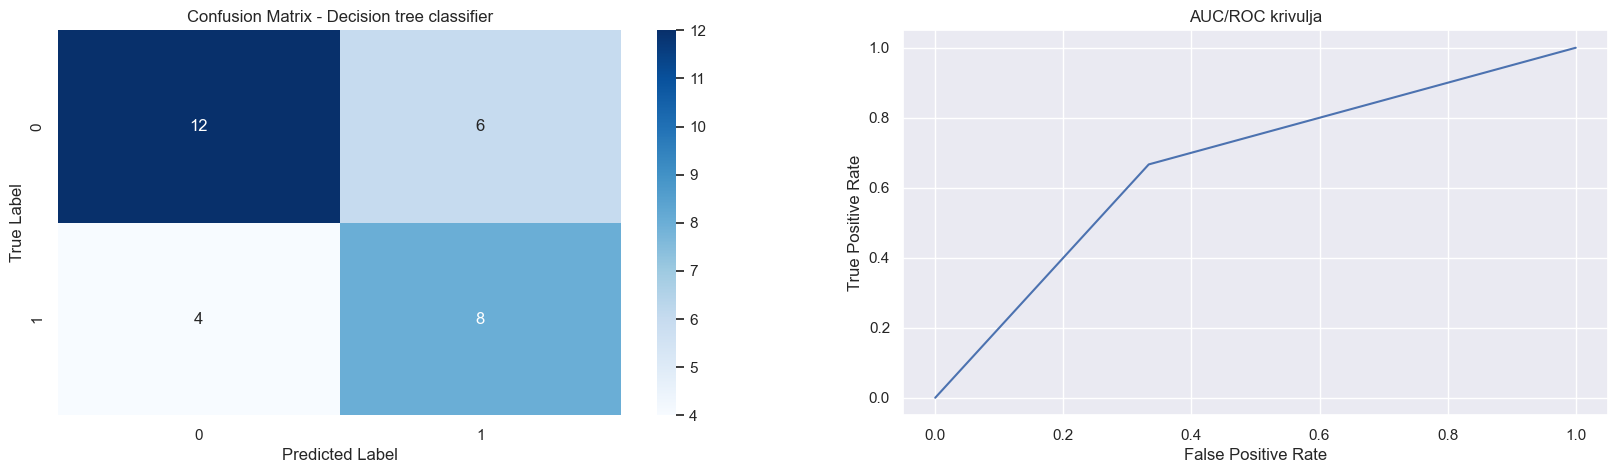

In [174]:
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(x_train, y_train)

decision_tree_predictins = decision_tree_model.predict(x_test)

print_scores(y_test, decision_tree_predictins, "Decision tree classifier")
print_graphs(y_test, decision_tree_predictins, decision_tree_model, "Decision tree classifier")

## RANDOM FOREST CLASSIFIER
Testiranje preciznosti random forest classifier modela


Evaluacija modela: Random forest classifier
-> Accuracy:  63.33%
-> Precision: 0.6533
-> Recall:    0.6333
-> F1 Score:  0.6370


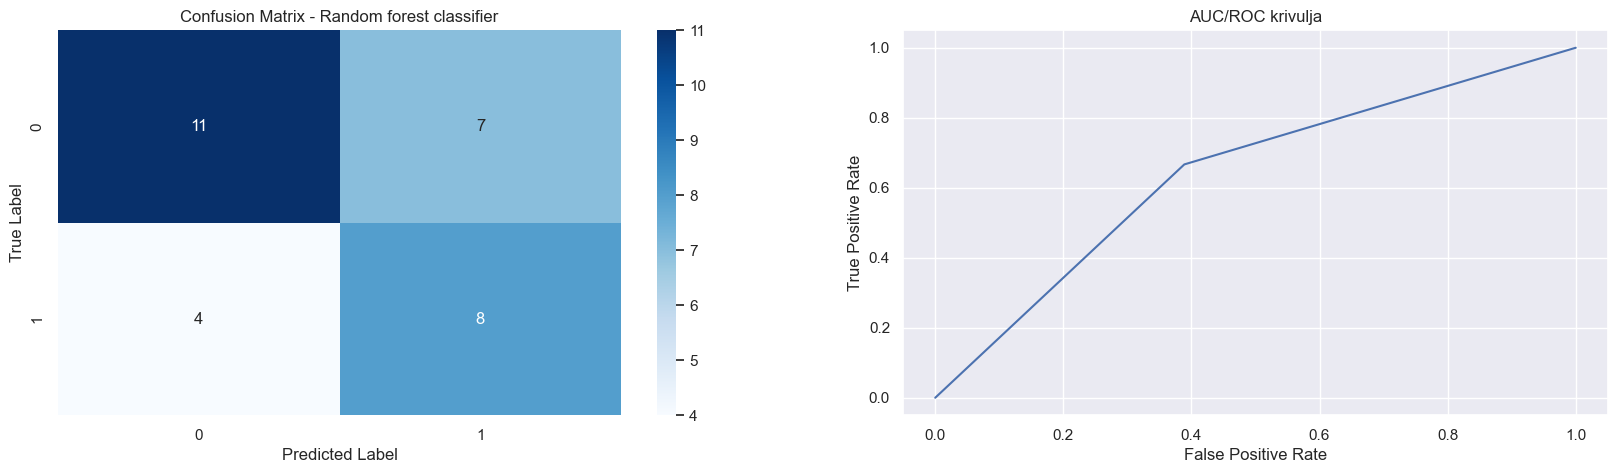

In [175]:
random_forest_model = RandomForestClassifier()
random_forest_model.fit(x_train, y_train)

random_forest_predictiones = random_forest_model.predict(x_test)

print_scores(y_test, random_forest_predictiones, "Random forest classifier")
print_graphs(y_test, random_forest_predictiones, random_forest_model, "Random forest classifier")

## SUPPORT VECTOR MACHINE
Testiranje preciznosti support vector machine modela


Evaluacija modela: Support vector machine
-> Accuracy:  66.67%
-> Precision: 0.6964
-> Recall:    0.6667
-> F1 Score:  0.6696


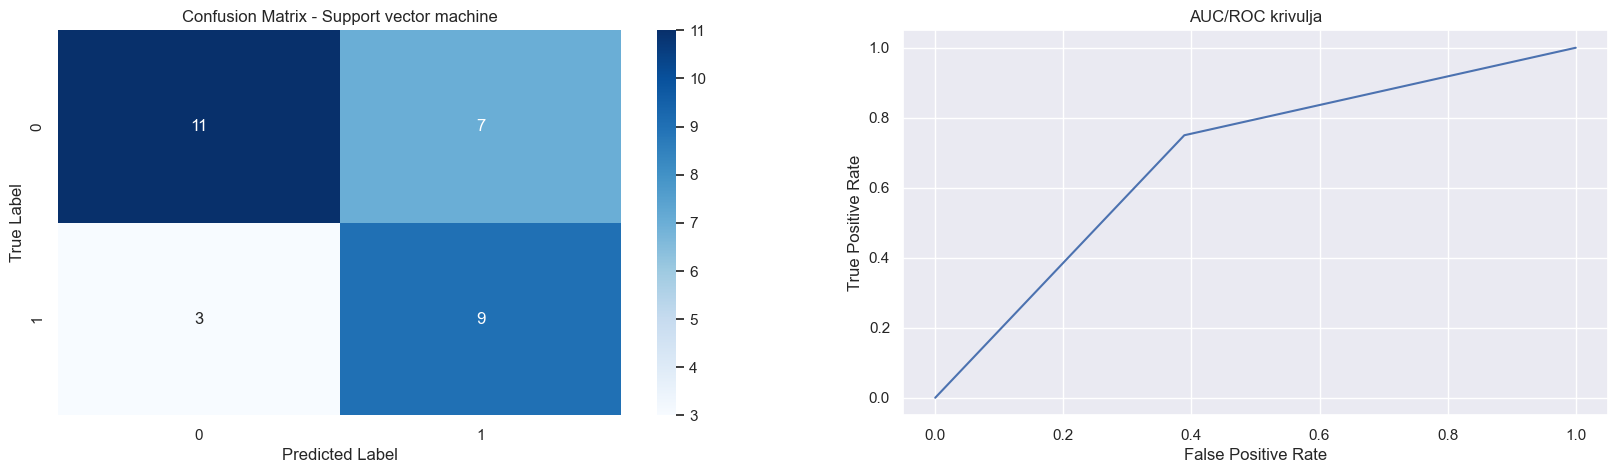

In [176]:
support_vector_machine = SVC(kernel='linear', probability=True)
support_vector_machine.fit(x_train, y_train)

support_vector_machine_predictions = support_vector_machine.predict(x_test)

print_scores(y_test, support_vector_machine_predictions, "Support vector machine")
print_graphs(y_test, support_vector_machine_predictions, support_vector_machine, "Support vector machine")

### XGBOOST
Testiranje preciznosti xgboost modela


Evaluacija modela: XGBoost
-> Accuracy:  63.33%
-> Precision: 0.6533
-> Recall:    0.6333
-> F1 Score:  0.6370


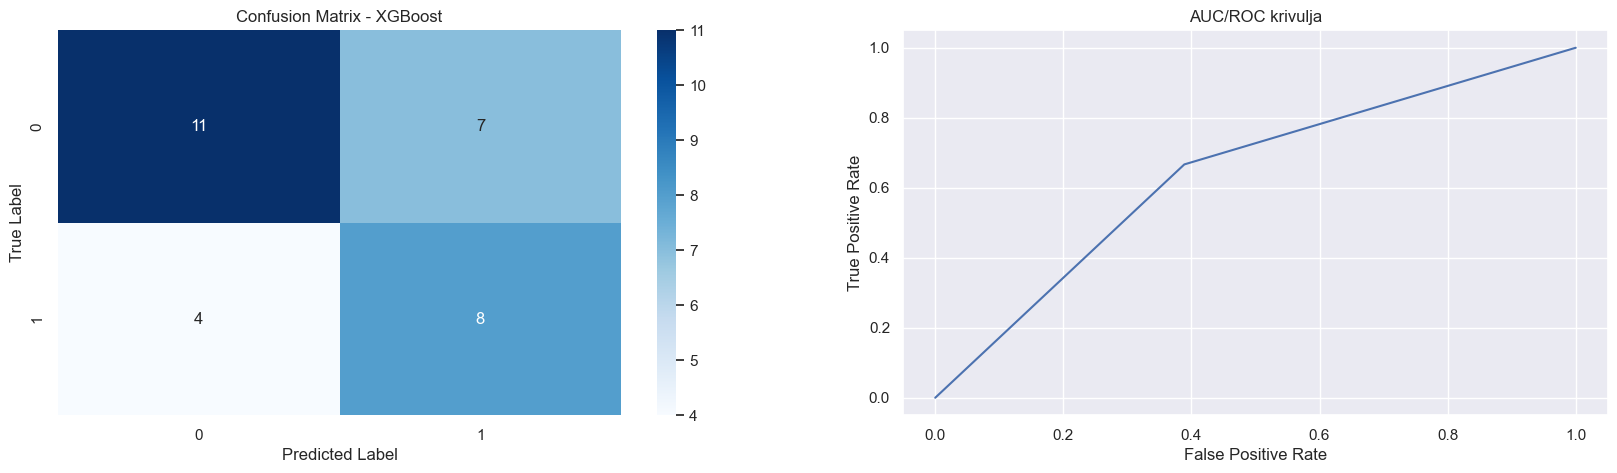

In [177]:
xgboost_model = XGBClassifier()
xgboost_model.fit(x_train, y_train)

xgboost_predictions = xgboost_model.predict(x_test)

print_scores(y_test, xgboost_predictions, "XGBoost")
print_graphs(y_test, xgboost_predictions, xgboost_model, "XGBoost")

## VOTING CLASSIFIER
Testiranje preciznosti voting classifier modela


Evaluacija modela: Voting classifier
-> Accuracy:  63.33%
-> Precision: 0.6389
-> Recall:    0.6333
-> F1 Score:  0.6354


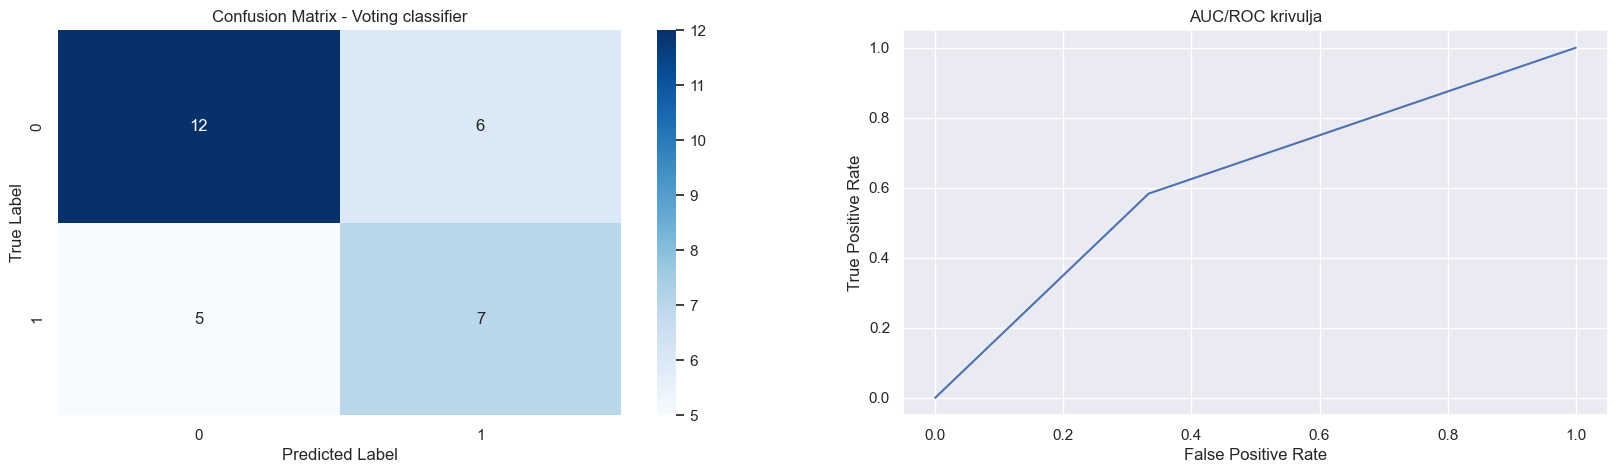

In [178]:
estimators = [('dt', decision_tree_model), ('svm', support_vector_machine), ('rf', random_forest_model), ('xgb', xgboost_model)]
voting_model = VotingClassifier(estimators = estimators, voting = 'soft')
voting_model.fit(x_train, y_train)

voting_pred = voting_model.predict(x_test)

print_scores(y_test, voting_pred, "Voting classifier")
print_graphs(y_test, voting_pred, voting_model, "Voting classifier")

## Pregled performansi pojedinih modela
U ovom poglavlju radimo analizu svih istreniranih modela i njihovih rezultata te ćemo ih međusobno usporediti.

                          Accuracy  Precision    Recall  F1-score
Decision tree classifier  0.666667   0.678571  0.666667  0.669683
Random forest classifier  0.633333   0.653333  0.633333  0.637037
Support vector machine    0.666667   0.696429  0.666667  0.669643
XGBoost                   0.633333   0.653333  0.633333  0.637037
Voting classifier         0.633333   0.638914  0.633333  0.635429



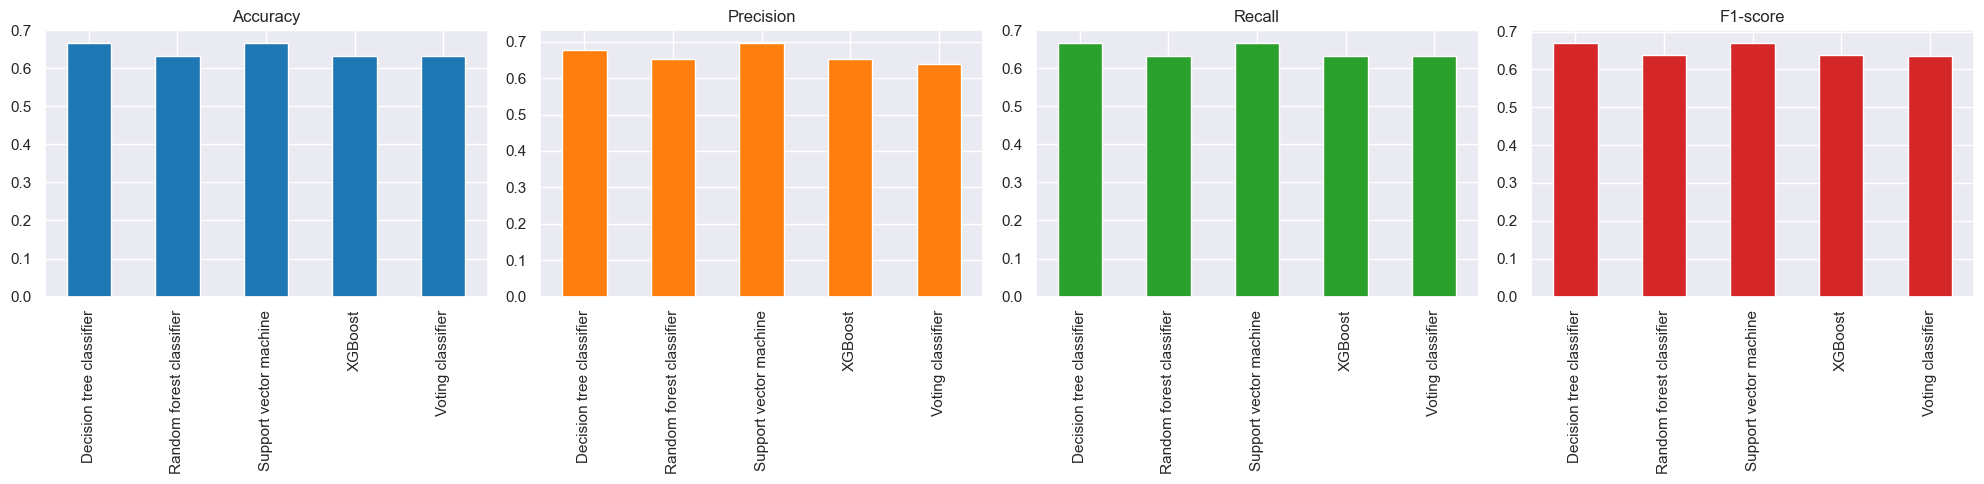

In [192]:
print("=================================================================")
print(df)
print("=================================================================\n")
num_cols = len(df.columns)
fig_, axes = plt.subplots(1, num_cols, figsize=(5 * num_cols, 5))
plot_colors = plt.get_cmap("tab10").colors

for i, (col, color) in enumerate(zip(df.columns, plot_colors)):
    df[col].plot(kind='bar', ax=axes[i], color=color)
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

### Zaključak o modelima
Prema podacima iz tablice i nacrtanimg grafovima možemo zaključiti: 
- SVM i Decision Tree pokazuju najbolje performanse, s najvišim F1-score-om (~0.67) i preciznošću.
- Random Forest i XGBoost imaju nešto slabije rezultate (F1-score ~0.63), što sugerira da nisu idealni za ovaj problem.
- Voting Classifier nije poboljšao točnost, što znači da kombinacija modela nije donijela dodatnu vrijednost